<a href="https://colab.research.google.com/github/ars-akash/glucoma-detection-cnn/blob/main/UNET_RIM_ONE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import IPython.display as ipd
import matplotlib.pyplot as plt#graph plotting
import numpy as np#Array or Multi dimi. arrays
import pandas as pd#Reading files and sving it as tablur format
import time
from collections import Counter, OrderedDict #[1,2,3,3]
import cv2 
from google.colab.patches import cv2_imshow #Is used for printing the images
import random #Generating random variables or values
from natsort import natsorted
from scipy.ndimage import rotate

#sklearn - scikit-learn - form machine learning algorithms
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight
 
import tensorflow as tf
import keras 
from keras.utils.np_utils import to_categorical
from keras.layers import Dense, Dropout, Flatten, Conv2D, Conv1D, UpSampling2D, MaxPooling2D, MaxPooling1D, LeakyReLU, Conv2DTranspose, Concatenate, Conv1DTranspose
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop,Adamax, Nadam
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.models import load_model
from keras.models import Input
from keras.layers.merge import concatenate, add
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
from keras import backend as K
from matplotlib import pyplot
from numpy import expand_dims
 
from tqdm import tqdm_notebook as tq # Progressing bar

import tensorflow as tf
 
import glob
from datetime import datetime
import scipy as sp
import scipy.ndimage
import numpy as np
import pandas as pd
import tensorflow as tf
import skimage
import skimage.exposure
from sklearn.model_selection import KFold
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import h5py
from tqdm import tqdm_notebook
from IPython.display import display
import keras, tensorflow
from keras.models import Sequential, Model
from keras.utils import np_utils


In [ ]:
def lossFunc(true, pred):

      axis = 1 
      weightsList = [ 0.50584834, 43.24720015]
      classSelectors = K.argmax(true, axis=axis) 
      classSelectors = [K.equal(K.cast(i,tf.int64), classSelectors) for i in range(len(weightsList))]
      classSelectors = [K.cast(x, K.floatx()) for x in classSelectors]
      weights = [sel * w for sel,w in zip(classSelectors, weightsList)] 
      weightMultiplier = weights[0]
      for i in range(1, len(weights)):
          weightMultiplier = weightMultiplier + weights[i]
      loss = keras.losses.categorical_crossentropy(true,pred) 
      loss = loss * weightMultiplier

      return loss


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
K.set_image_data_format('channels_first')

In [ ]:
def mean_IOU_gpu(X, Y):
    X_fl = K.clip(K.batch_flatten(X), 0., 1.)
    Y_fl = K.clip(K.batch_flatten(Y), 0., 1.)
    X_fl = K.cast(K.greater(X_fl, 0.5), 'float32')
    Y_fl = K.cast(K.greater(Y_fl, 0.5), 'float32')

    intersection = K.sum(X_fl * Y_fl, axis=1)
    union = K.sum(K.maximum(X_fl, Y_fl), axis=1)
    union = K.switch(K.equal(union, 0), K.ones_like(union), union)
    return K.mean(intersection / K.cast(union, 'float32'))


def mean_IOU_gpu_loss(X, Y):
    return -mean_IOU_gpu(X, Y)

def dice(y_true, y_pred):
    y_true_f = K.clip(K.batch_flatten(y_true), 0., 1.)
    y_pred_f = K.clip(K.batch_flatten(y_pred), 0., 1.)

    intersection = 2 * K.sum(y_true_f * y_pred_f, axis=1)
    union = K.sum(y_true_f * y_true_f, axis=1) + K.sum(y_pred_f * y_pred_f, axis=1)
    return K.mean(intersection / union)


def dice_loss(y_true, y_pred):
    return -dice(y_true, y_pred)


def log_dice_loss(y_true, y_pred):
    print(y_true.shape, y_pred.shape)
    return -K.log(dice(y_true, y_pred))


def dice_metric(y_true, y_pred):
    """An exact Dice score for binary tensors."""
    y_true_f = K.cast(K.greater(y_true, 0.5), 'float32')
    y_pred_f = K.cast(K.greater(y_pred, 0.5), 'float32')
    return dice(y_true_f, y_pred_f)


# RIM-ONE V3

In [ ]:
!git clone https://github.com/seva100/optic-nerve-cnn.git

Cloning into 'optic-nerve-cnn'...
remote: Enumerating objects: 7634, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 7634 (delta 0), reused 2 (delta 0), pack-reused 7631
Receiving objects: 100% (7634/7634), 706.89 MiB | 31.63 MiB/s, done.
Resolving deltas: 100% (3044/3044), done.
Checking out files: 100% (7340/7340), done.


Image Augmentation

In [ ]:
# # Image Augumentation for Glaucoma and suspects (stereo images) and healthy (stereo images)

# from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
# datagen = ImageDataGenerator(rotation_range =15, 
#                          width_shift_range = 0.2, 
#                          height_shift_range = 0.2)


# img_dir1 = "/content/optic-nerve-cnn/data/RIM-ONE v3/Glaucoma and suspects/Stereo Images" 
# img_dir2 = "/content/optic-nerve-cnn/data/RIM-ONE v3/Healthy/Stereo Images"

# data_path1 = os.path.join(img_dir1,'*g')

# files1 = glob.glob(data_path1)

# data_path2 = os.path.join(img_dir2,'*g')

# files2 = glob.glob(data_path2)

# data1 = []
# data2 = []

# for f1 in files1:
#     img1 = cv2.imread(f1)
#     data1.append(img1)

# for f2 in files2:
#     img2 = cv2.imread(f2)
#     data2.append(img2)

# x1 = img_to_array(img1)
# x1 = x1.reshape((1,) + x1.shape)

# x2 = img_to_array(img2)
# x2 = x2.reshape((1,) + x2.shape)

# i = 0
# path, dirs, files11 = next(os.walk("/content/optic-nerve-cnn/data/RIM-ONE v3/Glaucoma and suspects/Stereo Images"))
# file_count = len(files11) #to find number of files in folder
# print('file_count for G and S: ', file_count)
# os.mkdir('/content/optic-nerve-cnn/data/RIM-ONE v3/Glaucoma and suspects/Stereo Images2')
# for batch in datagen.flow (x1, batch_size=10, save_to_dir =r'/content/optic-nerve-cnn/data/RIM-ONE v3/Glaucoma and suspects/Stereo Images2',save_prefix="q",save_format='jpg'):
#     i+=1
#     if i==file_count:
#       break

# j = 0
# path, dirs, files22 = next(os.walk("/content/optic-nerve-cnn/data/RIM-ONE v3/Healthy/Stereo Images"))
# file_count = len(files22) #to find number of files in folder
# print('file_count for healthy: ', file_count)
# os.mkdir('/content/optic-nerve-cnn/data/RIM-ONE v3/Healthy/Stereo Images2')
# for batch in datagen.flow (x2, batch_size=10, save_to_dir =r'/content/optic-nerve-cnn/data/RIM-ONE v3/Healthy/Stereo Images2',save_prefix="q",save_format='jpg'):
#     j+=1
#     if j==file_count:
#       break

file_count for G and S:  74
file_count for healthy:  85


In [ ]:
img = []
path = '/content/optic-nerve-cnn/data/RIM-ONE v3/Glaucoma and suspects/Average_masks'
for i in tq(natsorted(os.listdir(path))):
  if('.png' in i):
    ii = cv2.imread(os.path.join(path, i))
    img.append(ii.shape)

  0%|          | 0/444 [00:00<?, ?it/s]

In [ ]:
Counter(img) #for counting the number of images and the hasable objects 

Counter({(1424, 2144, 3): 148})

In [ ]:
Counter({(1424, 2144, 3): 74})
Counter({(1424, 2144, 3): 85})

Counter({(1424, 2144, 3): 85})

# For OD

In [ ]:
x = []
y = []
path1 = '/content/optic-nerve-cnn/data/RIM-ONE v3/Glaucoma and suspects'
path2 = '/content/optic-nerve-cnn/data/RIM-ONE v3/Healthy'
for path in [path1, path2]:
  for img_name in tq(natsorted(os.listdir(os.path.join(path, 'Stereo Images')))):
    x_img = cv2.imread(os.path.join(path, 'Stereo Images', img_name))
    mask_name = img_name.split('.')[0]+'-Disc-Avg.png'
    mask_img = cv2.imread(os.path.join(path, 'Average_masks', mask_name), 0)
    mask_img = cv2.equalizeHist(mask_img)
    mask_img1 = mask_img[0:1424, 0:1072]
    mask_img2 = mask_img[0:1424, 1072:]
    
    if(255 in list(np.unique(mask_img1))):
      x_img = x_img[0:1424, 0:1072]
      x_img = cv2.resize(x_img, (256, 256))

      y_img = mask_img1.copy()
      y_img = cv2.resize(y_img, (256, 256))
      y_img[y_img<127] = 0
      y_img[y_img>=127] = 255
      
    elif(255 in list(np.unique(mask_img2))):
      x_img = x_img[0:1424, 1072:]
      x_img = cv2.resize(x_img, (256, 256))

      y_img = mask_img2.copy()
      y_img = cv2.resize(y_img, (256, 256))
      y_img[y_img<127] = 0
      y_img[y_img>=127] = 255

    else:
      print('Not good', img_name, mask_name)

    x.append(x_img)
    y.append(y_img)

x = np.array(x)
y = np.array(y)

  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

In [ ]:
x.shape, y.shape

((159, 256, 256, 3), (159, 256, 256))

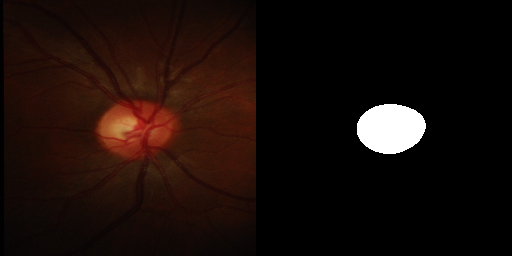

In [ ]:
ind = 105
cv2_imshow(cv2.hconcat([x[ind], cv2.merge([y[ind], y[ind], y[ind]])]))

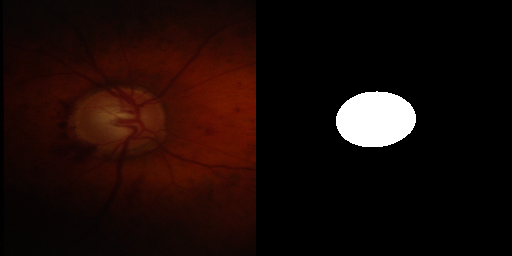

In [ ]:
ind = 20
cv2_imshow(cv2.hconcat([x[ind], cv2.merge([y[ind], y[ind], y[ind]])]))

In [ ]:
np.unique(y)

array([  0, 255], dtype=uint8)

In [ ]:
y[y==255] = 1
np.unique(y, return_counts=True)

(array([0, 1], dtype=uint8), array([9985150,  435074]))

In [ ]:
x = x/255
x.shape

(159, 256, 256, 3)

In [ ]:
y = y.reshape((159, 256, 256, 1))
y.shape

(159, 256, 256, 1)

In [ ]:
trainX, testX, trainY, testY = train_test_split(x, y, test_size=0.2, random_state=16)
 
x = y = nps = uni = Y = y_images = 0
trainX.shape, testX.shape, trainY.shape, testY.shape

((127, 256, 256, 3), (32, 256, 256, 3), (127, 256, 256, 1), (32, 256, 256, 1))

In [ ]:
trainX = trainX.transpose(0, 3, 1, 2)
trainY = trainY.transpose(0, 3, 1, 2)
testX = testX.transpose(0, 3, 1, 2)
testY = testY.transpose(0, 3, 1, 2)
trainX.shape, trainY.shape, testX.shape, testY.shape

((127, 3, 256, 256), (127, 1, 256, 256), (32, 3, 256, 256), (32, 1, 256, 256))

In [ ]:
x_img = y_img = y_images = mask_img1 = mask_img2 = im = img_name = mask_img = 0

In [ ]:
trainX.dtype, trainY.dtype, testX.dtype, testY.dtype

(dtype('float64'), dtype('uint8'), dtype('float64'), dtype('uint8'))

In [ ]:
trainY = trainY.astype('float64')
testY = testY.astype('float64')

In [ ]:
from keras.callbacks import Callback,ModelCheckpoint
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
def unet_od(img_rows=256, img_cols=256):
    inputs = Input((3, img_rows, img_cols))
    conv1 = Conv2D(64, kernel_size=3, activation='LeakyReLU', padding='same')(inputs)
    conv1 = Dropout(0.3)(conv1)
    conv1 = Conv2D(64, kernel_size=3, activation='LeakyReLU', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, kernel_size=3, activation='LeakyReLU', padding='same')(pool1)
    conv2 = Dropout(0.3)(conv2)
    conv2 = Conv2D(64, kernel_size=3, activation='LeakyReLU', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(64, kernel_size=3, activation='LeakyReLU', padding='same')(pool2)
    conv3 = Dropout(0.3)(conv3)
    conv3 = Conv2D(64, kernel_size=3, activation='LeakyReLU', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(64, kernel_size=3, activation='LeakyReLU', padding='same')(pool3)
    conv4 = Dropout(0.3)(conv4)
    conv4 = Conv2D(64, kernel_size=3, activation='LeakyReLU', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(64, kernel_size=3, activation='LeakyReLU', padding='same')(pool4)
    conv5 = Dropout(0.3)(conv5)
    conv5 = Conv2D(64, kernel_size=3, activation='LeakyReLU', padding='same')(conv5)

    up6 = Concatenate(axis=1)([UpSampling2D(size=(2, 2))(conv5), conv4])
    conv6 = Conv2D(64, kernel_size=3, activation='LeakyReLU', padding='same')(up6)
    conv6 = Dropout(0.3)(conv6)
    conv6 = Conv2D(64, kernel_size=3, activation='LeakyReLU', padding='same')(conv6)

    up7 = Concatenate(axis=1)([UpSampling2D(size=(2, 2))(conv6), conv3])
    conv7 = Conv2D(64, kernel_size=3, activation='LeakyReLU', padding='same')(up7)
    conv7 = Dropout(0.3)(conv7)
    conv7 = Conv2D(64, kernel_size=3, activation='LeakyReLU', padding='same')(conv7)

    up8 = Concatenate(axis=1)([UpSampling2D(size=(2, 2))(conv7), conv2])
    conv8 = Conv2D(64, kernel_size=3, activation='LeakyReLU', padding='same')(up8)
    conv8 = Dropout(0.3)(conv8)
    conv8 = Conv2D(64, kernel_size=3, activation='LeakyReLU', padding='same')(conv8)

    up9 = Concatenate(axis=1)([UpSampling2D(size=(2, 2))(conv8), conv1])
    conv9 = Conv2D(32, kernel_size=3, activation='LeakyReLU', padding='same')(up9)
    conv9 = Dropout(0.3)(conv9)
    conv9 = Conv2D(32, kernel_size=3, activation='LeakyReLU', padding='same')(conv9)

    conv10 = Conv2D(1, kernel_size=1, activation='tanh', padding='same')(conv9)
    #conv10 = Flatten()(conv10)

    model = Model(inputs=inputs, outputs=conv10)

    return model
model = unet_od(img_rows=256, img_cols=256)
model.compile(optimizer=SGD(lr=1e-3, momentum=0.95),
              loss=log_dice_loss,
              metrics=[mean_IOU_gpu, dice_metric])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 3, 256, 256  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 256, 256  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 64, 256, 256  0           ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
%%time
red_lr= ReduceLROnPlateau(monitor='val_loss',patience=9,verbose=2,factor=0.001,min_delta=0.01)
filepath = r"/content/drive/MyDrive/final-mid/od.h5"
check=ModelCheckpoint(filepath = filepath, verbose = 1, save_best_only = True)

H = model.fit(
    trainX, trainY,
    validation_data=(testX, testY),
    callbacks = [check, ],
    batch_size=8,
    epochs=250,
    verbose=2,
  )

Epoch 1/250
(None, 1, 256, 256) (None, 1, 256, 256)
(None, 1, 256, 256) (None, 1, 256, 256)
(8, 1, 256, 256) (8, 1, 256, 256)

Epoch 1: val_loss improved from inf to 1.62659, saving model to /content/drive/MyDrive/final-mid/od.h5
16/16 - 18s - loss: 1.8458 - mean_IOU_gpu: 0.0795 - dice_metric: 0.1331 - val_loss: 1.6266 - val_mean_IOU_gpu: 0.1757 - val_dice_metric: 0.2550 - 18s/epoch - 1s/step
Epoch 2/250

Epoch 2: val_loss improved from 1.62659 to 0.68943, saving model to /content/drive/MyDrive/final-mid/od.h5
16/16 - 2s - loss: 1.1354 - mean_IOU_gpu: 0.1831 - dice_metric: 0.2678 - val_loss: 0.6894 - val_mean_IOU_gpu: 0.2476 - val_dice_metric: 0.3403 - 2s/epoch - 100ms/step
Epoch 3/250

Epoch 3: val_loss improved from 0.68943 to 0.51972, saving model to /content/drive/MyDrive/final-mid/od.h5
16/16 - 2s - loss: 0.7328 - mean_IOU_gpu: 0.3327 - dice_metric: 0.4416 - val_loss: 0.5197 - val_mean_IOU_gpu: 0.4418 - val_dice_metric: 0.5659 - 2s/epoch - 99ms/step
Epoch 4/250

Epoch 4: val_loss 

## accuracy

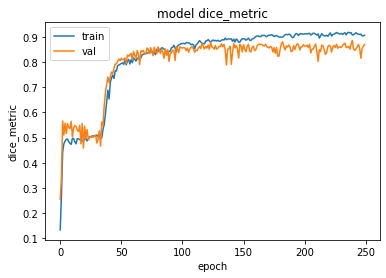

In [ ]:
plt.plot(H.history['dice_metric'])
plt.plot(H.history['val_dice_metric'])
plt.title('model dice_metric')
plt.ylabel('dice_metric')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## loss graph

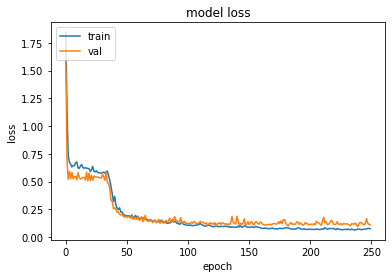

In [ ]:
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## mean IOU graph

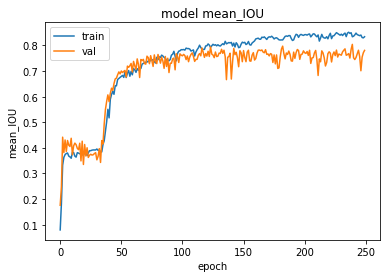

In [ ]:
plt.plot(H.history['mean_IOU_gpu'])
plt.plot(H.history['val_mean_IOU_gpu'])
plt.title('model mean_IOU')
plt.ylabel('mean_IOU')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# For OC

In [ ]:
x = []
y = []
for path in [path1, path2]:
  for img_name in tq(natsorted(os.listdir(os.path.join(path, 'Stereo Images')))):
    x_img = cv2.imread(os.path.join(path, 'Stereo Images', img_name))
    mask_name = img_name.split('.')[0]+'-Cup-Avg.png'
    mask_img = cv2.imread(os.path.join(path, 'Average_masks', mask_name), 0)
    mask_img = cv2.equalizeHist(mask_img)
    mask_img1 = mask_img[0:1424, 0:1072]
    mask_img2 = mask_img[0:1424, 1072:]
    
    if(255 in list(np.unique(mask_img1))):
      x_img = x_img[0:1424, 0:1072]
      x_img = cv2.resize(x_img, (256, 256))

      y_img = mask_img1.copy()
      y_img = cv2.resize(y_img, (256, 256))
      y_img[y_img<127] = 0
      y_img[y_img>=127] = 255
      
    elif(255 in list(np.unique(mask_img2))):
      x_img = x_img[0:1424, 1072:]
      x_img = cv2.resize(x_img, (256, 256))

      y_img = mask_img2.copy()
      y_img = cv2.resize(y_img, (256, 256))
      y_img[y_img<127] = 0
      y_img[y_img>=127] = 255

    else:
      print('Not good', img_name, mask_name)

    x.append(x_img)
    y.append(y_img)
    x.append(cv2.flip(x_img, 0))
    y.append(cv2.flip(y_img, 0))
    x.append(cv2.flip(x_img, 1))
    y.append(cv2.flip(y_img, 1))
    x.append(cv2.flip(x_img, -1))
    y.append(cv2.flip(y_img, -1))

x = np.array(x)
y = np.array(y)

  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

In [ ]:
x.shape, y.shape

((636, 256, 256, 3), (636, 256, 256))

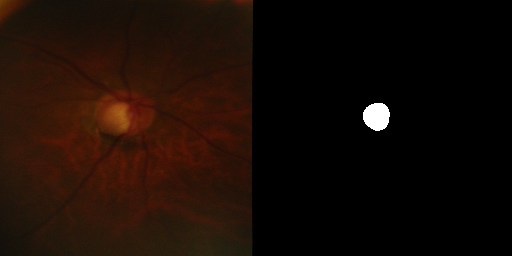

In [ ]:
ind = 170
cv2_imshow(cv2.hconcat([x[ind], cv2.merge([y[ind], y[ind], y[ind]])]))

In [ ]:
np.unique(y)

array([  0, 255], dtype=uint8)

In [ ]:
y[y==255] = 1
np.unique(y, return_counts=True)

(array([0, 1], dtype=uint8), array([41198736,   482160]))

In [ ]:
y.shape

(636, 256, 256)

In [ ]:
y = y.reshape((636,256,256,1))

In [ ]:
x = x/255
x.shape

(636, 256, 256, 3)

In [ ]:
(trainX, testX, trainY, testY) = train_test_split(x, y, test_size=0.2, random_state=11)
 
x = y = nps = uni = Y = y_images = 0
trainX.shape, testX.shape, trainY.shape, testY.shape

((508, 256, 256, 3),
 (128, 256, 256, 3),
 (508, 256, 256, 1),
 (128, 256, 256, 1))

In [ ]:
x_img = y_img = y_images = mask_img1 = mask_img2 = im = img_name = mask_img = 0

In [ ]:
trainX = trainX.transpose(0, 3, 1, 2)
trainY = trainY.transpose(0, 3, 1, 2)
testX = testX.transpose(0, 3, 1, 2)
testY = testY.transpose(0, 3, 1, 2)
trainX.shape, trainY.shape, testX.shape, testY.shape

((508, 3, 256, 256),
 (508, 1, 256, 256),
 (128, 3, 256, 256),
 (128, 1, 256, 256))

In [ ]:
trainY = trainY.astype('float64')
testY = testY.astype('float64')

In [ ]:
def unet_oc(img_rows=256, img_cols=256):
    inputs = Input((3, img_rows, img_cols))
    conv1 = Conv2D(64, kernel_size=3, activation='LeakyReLU', padding='same')(inputs)
    conv1 = Dropout(0.3)(conv1)
    conv1 = Conv2D(64, kernel_size=3, activation='LeakyReLU', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, kernel_size=3, activation='LeakyReLU', padding='same')(pool1)
    conv2 = Dropout(0.3)(conv2)
    conv2 = Conv2D(64, kernel_size=3, activation='LeakyReLU', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(64, kernel_size=3, activation='LeakyReLU', padding='same')(pool2)
    conv3 = Dropout(0.3)(conv3)
    conv3 = Conv2D(64, kernel_size=3, activation='LeakyReLU', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(64, kernel_size=3, activation='LeakyReLU', padding='same')(pool3)
    conv4 = Dropout(0.3)(conv4)
    conv4 = Conv2D(64, kernel_size=3, activation='LeakyReLU', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(64, kernel_size=3, activation='LeakyReLU', padding='same')(pool4)
    conv5 = Dropout(0.3)(conv5)
    conv5 = Conv2D(64, kernel_size=3, activation='LeakyReLU', padding='same')(conv5)

    up6 = Concatenate(axis=1)([UpSampling2D(size=(2, 2))(conv5), conv4])
    conv6 = Conv2D(64, kernel_size=3, activation='LeakyReLU', padding='same')(up6)
    conv6 = Dropout(0.3)(conv6)
    conv6 = Conv2D(64, kernel_size=3, activation='LeakyReLU', padding='same')(conv6)

    up7 = Concatenate(axis=1)([UpSampling2D(size=(2, 2))(conv6), conv3])
    conv7 = Conv2D(64, kernel_size=3, activation='LeakyReLU', padding='same')(up7)
    conv7 = Dropout(0.3)(conv7)
    conv7 = Conv2D(64, kernel_size=3, activation='LeakyReLU', padding='same')(conv7)

    up8 = Concatenate(axis=1)([UpSampling2D(size=(2, 2))(conv7), conv2])
    conv8 = Conv2D(64, kernel_size=3, activation='LeakyReLU', padding='same')(up8)
    conv8 = Dropout(0.3)(conv8)
    conv8 = Conv2D(64, kernel_size=3, activation='LeakyReLU', padding='same')(conv8)

    up9 = Concatenate(axis=1)([UpSampling2D(size=(2, 2))(conv8), conv1])
    conv9 = Conv2D(32, kernel_size=3, activation='LeakyReLU', padding='same')(up9)
    conv9 = Dropout(0.3)(conv9)
    conv9 = Conv2D(32, kernel_size=3, activation='LeakyReLU', padding='same')(conv9)

    conv10 = Conv2D(1, kernel_size=1, activation='tanh', padding='same')(conv9)
    #conv10 = Flatten()(conv10)

    model_oc = Model(inputs=inputs, outputs=conv10)

    return model
model_oc = unet_oc(img_rows=256, img_cols=256)
model_oc.compile(optimizer=SGD(lr=1e-3, momentum=0.95),
              loss=log_dice_loss,
              metrics=[mean_IOU_gpu, dice_metric])

model_oc.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 3, 256, 256  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 256, 256  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 64, 256, 256  0           ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
%%time
red_lr= ReduceLROnPlateau(monitor='val_loss',patience=9,verbose=2,factor=0.001,min_delta=0.01)
filepath = r"/content/drive/MyDrive/eye_glaucoma/oc_11.h5"#-{epoch:02d}-{loss:.4f}-{accuracy:.4f}-{get_f1:.4f}-{val_loss:.4f}-{val_accuracy:.4f}-{val_get_f1:.4f}.h5"
check=ModelCheckpoint(filepath = filepath, verbose = 1, save_best_only = True)

H = model_oc.fit(
    trainX, trainY,
    validation_data=(testX, testY),
    callbacks = [check, ],
    batch_size=8,
    epochs=200,
    #sample_weight=cl,
    verbose=2,
  )

Epoch 1/200
(None, 1, 256, 256) (None, 1, 256, 256)
(None, 1, 256, 256) (None, 1, 256, 256)
(8, 1, 256, 256) (8, 1, 256, 256)

Epoch 1: val_loss improved from inf to 0.44105, saving model to /content/drive/MyDrive/eye_glaucoma/oc_11.h5
64/64 - 9s - loss: 0.4833 - mean_IOU_gpu: 0.4345 - dice_metric: 0.5696 - val_loss: 0.4410 - val_mean_IOU_gpu: 0.4710 - val_dice_metric: 0.6028 - 9s/epoch - 146ms/step
Epoch 2/200

Epoch 2: val_loss improved from 0.44105 to 0.38705, saving model to /content/drive/MyDrive/eye_glaucoma/oc_11.h5
64/64 - 6s - loss: 0.3560 - mean_IOU_gpu: 0.5181 - dice_metric: 0.6524 - val_loss: 0.3871 - val_mean_IOU_gpu: 0.4932 - val_dice_metric: 0.6189 - 6s/epoch - 93ms/step
Epoch 3/200

Epoch 3: val_loss improved from 0.38705 to 0.36065, saving model to /content/drive/MyDrive/eye_glaucoma/oc_11.h5
64/64 - 6s - loss: 0.3452 - mean_IOU_gpu: 0.5228 - dice_metric: 0.6595 - val_loss: 0.3607 - val_mean_IOU_gpu: 0.5223 - val_dice_metric: 0.6542 - 6s/epoch - 96ms/step
Epoch 4/200



## accuracy

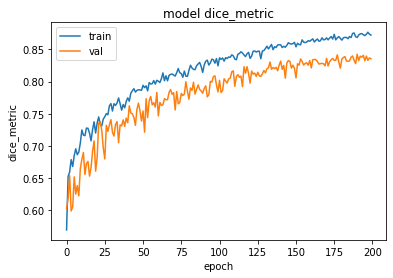

In [ ]:
plt.plot(H.history['dice_metric'])
plt.plot(H.history['val_dice_metric'])
plt.title('model dice_metric')
plt.ylabel('dice_metric')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## loss graph

In [ ]:
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## mean IOU graph

In [ ]:
plt.plot(H.history['mean_IOU_gpu'])
plt.plot(H.history['val_mean_IOU_gpu'])
plt.title('model mean_IOU')
plt.ylabel('mean_IOU')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()